Libraries

In [210]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


Import dataset and initial exploration

In [189]:
df = pd.read_csv('heart_disease_uci.csv', header= 0, index_col= 'id')
print(df.head())
print(df.describe())
print(df.info())

    age     sex    dataset               cp  trestbps   chol    fbs  \
id                                                                    
1    63    Male  Cleveland   typical angina     145.0  233.0   True   
2    67    Male  Cleveland     asymptomatic     160.0  286.0  False   
3    67    Male  Cleveland     asymptomatic     120.0  229.0  False   
4    37    Male  Cleveland      non-anginal     130.0  250.0  False   
5    41  Female  Cleveland  atypical angina     130.0  204.0  False   

           restecg  thalch  exang  oldpeak        slope   ca  \
id                                                             
1   lv hypertrophy   150.0  False      2.3  downsloping  0.0   
2   lv hypertrophy   108.0   True      1.5         flat  3.0   
3   lv hypertrophy   129.0   True      2.6         flat  2.0   
4           normal   187.0  False      3.5  downsloping  0.0   
5   lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                 thal  num  
id                      

EDA and preprocessing #1: rows deduplication

In [190]:
# Count of duplicate rows in raw dataframe
nb_doublons = df.duplicated().sum()
print(f"Nombre de lignes en doublons : {nb_doublons}")

#Since count is not 0, we proceed with deduplication
df.drop_duplicates(inplace= True)

Nombre de lignes en doublons : 2


EDA and preprocessing #2: Missing values management #1

In [191]:
# Evaluation of nan percentage for each feature
pourcentages_nan = (df.isnull().sum() / len(df)) * 100

# We put the resuls in a dataframe and sort values for easier on the eye display
tableau_nan = pd.DataFrame({
    'colonne': pourcentages_nan.index,
    'pourcentage_nan': pourcentages_nan.values
})

tableau_nan = tableau_nan.sort_values(by='pourcentage_nan', ascending=False).reset_index(drop=True)

print(tableau_nan)

#Feature 'num' will be our label. Therefore, it's nan value count is the reference value count. Here it's 918.

#Features 'ca', 'thal' and 'slope' show nan percentage greater than 30%. We decide to drop these features.
df.drop(columns=['ca', 'thal', 'slope'], axis=1, inplace=True)
print(df.head())

print(df.isna().sum())
print(df.shape)

     colonne  pourcentage_nan
0         ca        66.339869
1       thal        52.723312
2      slope        33.442266
3        fbs         9.803922
4    oldpeak         6.753813
5   trestbps         6.427015
6     thalch         5.991285
7      exang         5.991285
8       chol         3.159041
9    restecg         0.217865
10       age         0.000000
11       sex         0.000000
12   dataset         0.000000
13        cp         0.000000
14       num         0.000000
    age     sex    dataset               cp  trestbps   chol    fbs  \
id                                                                    
1    63    Male  Cleveland   typical angina     145.0  233.0   True   
2    67    Male  Cleveland     asymptomatic     160.0  286.0  False   
3    67    Male  Cleveland     asymptomatic     120.0  229.0  False   
4    37    Male  Cleveland      non-anginal     130.0  250.0  False   
5    41  Female  Cleveland  atypical angina     130.0  204.0  False   

           restecg  th

EDA and preprocessing #3: Distributions of numerical values

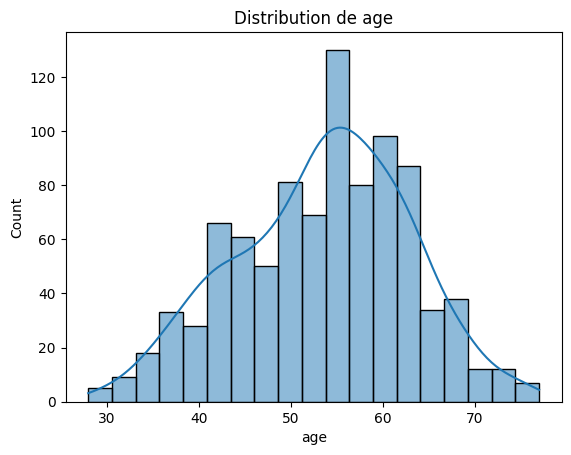

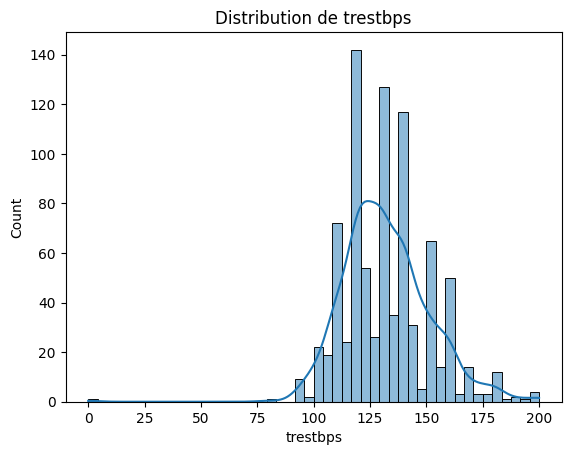

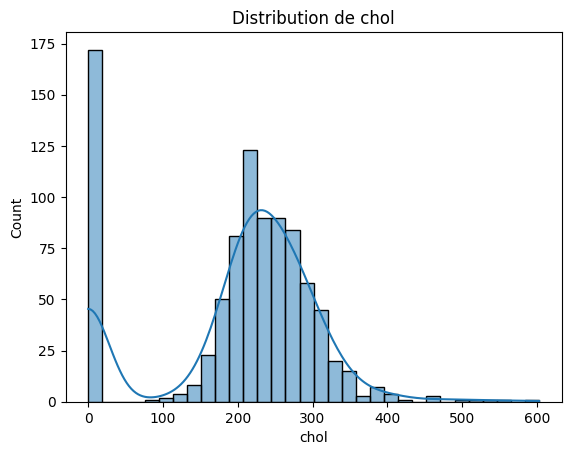

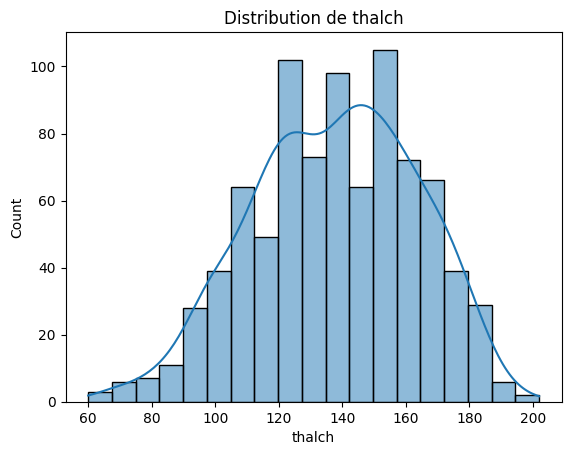

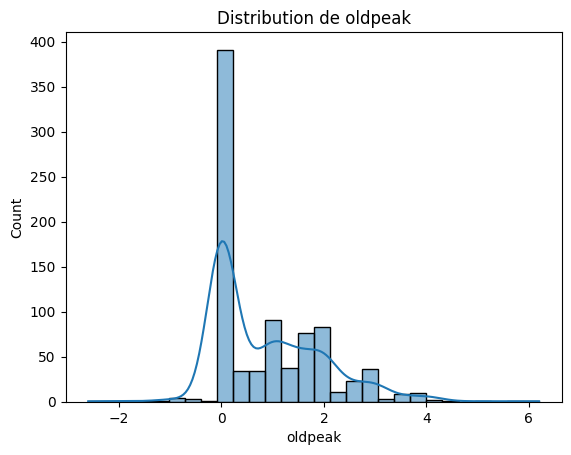

id
740    0.0
704    0.0
705    0.0
706    0.0
707    0.0
708    0.0
709    0.0
710    0.0
703    0.0
711    0.0
Name: chol, dtype: float64
172
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol        201
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
num           0
dtype: int64
(918, 12)


In [192]:
#Retriveve numerical features minus num
number_columns = df.select_dtypes(include=['int64', 'float64']).columns
number_columns = [col for col in number_columns if col != 'num']

#Display of numerical feautures distributions
for col in number_columns:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution de {col}')
    plt.show()

#Closer examination of zero value outlier in 'chol' feature
print(df['chol'].sort_values(ascending=True).head(10))
print(df[df['chol'] == 0]['chol'].count())

#172 zero values for 'chol'. Interpreted as 'input error'. Set as nan
df['chol'] = df['chol'].replace(0, np.nan)

print(df.isna().sum())
print(df.shape)

EDA and preprocessing #4: Outliers management

/var/folders/9m/2x6dfbbn0cq5m_g98d1wpw640000gn/T/ipykernel_57390/2062164384.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


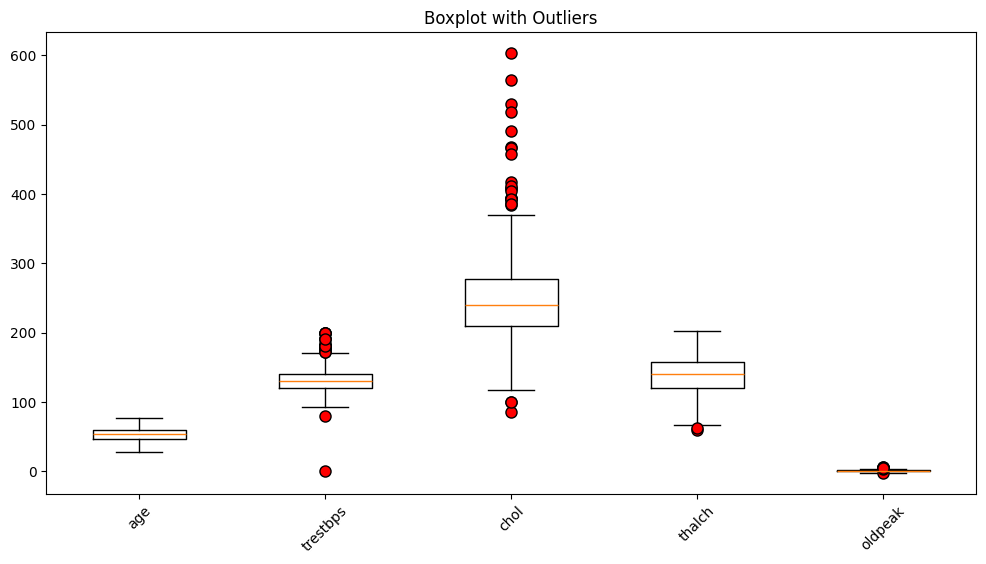

age           0
sex           0
dataset       0
cp            0
trestbps     59
chol        201
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
num           0
dtype: int64
(918, 12)


In [193]:
#Boxplot of outliers
plt.figure(figsize=(12, 6))
plt.boxplot(
    [df[col].dropna() for col in number_columns],
    labels=number_columns,
    flierprops=dict(marker='o', markerfacecolor='red', markersize=8)
)
plt.title('Boxplot with Outliers')
plt.xticks(rotation=45)
plt.show()

def winsorize_series(s, lower_percentile=10, upper_percentile=90):
    lower_cap = np.percentile(s.dropna(), lower_percentile)
    upper_cap = np.percentile(s.dropna(), upper_percentile)
    return s.clip(lower_cap, upper_cap)


for col in number_columns:
    df[col] = winsorize_series(df[col], 5, 95)

print(df.isna().sum())
print(df.shape)

EDA and preprocessing #5: Missing values on numerical features

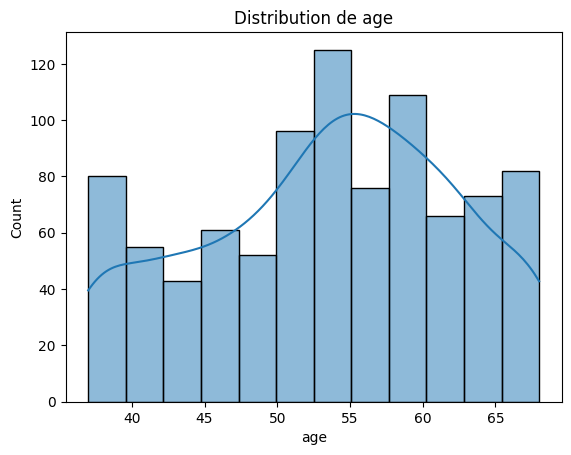

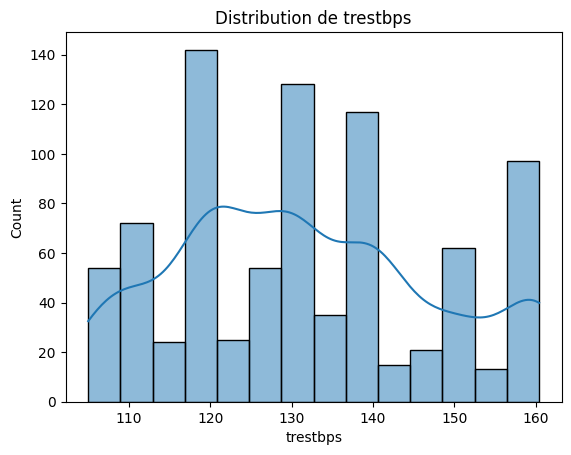

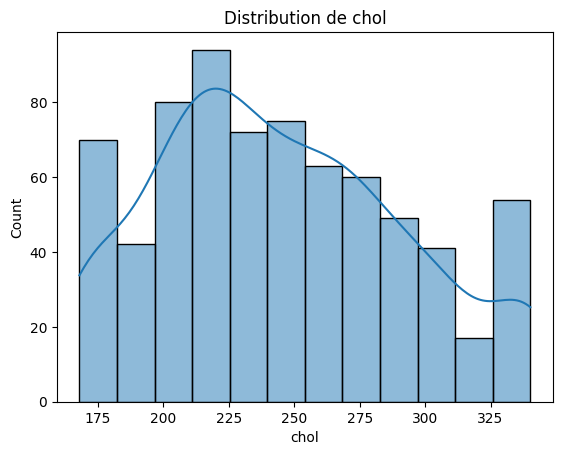

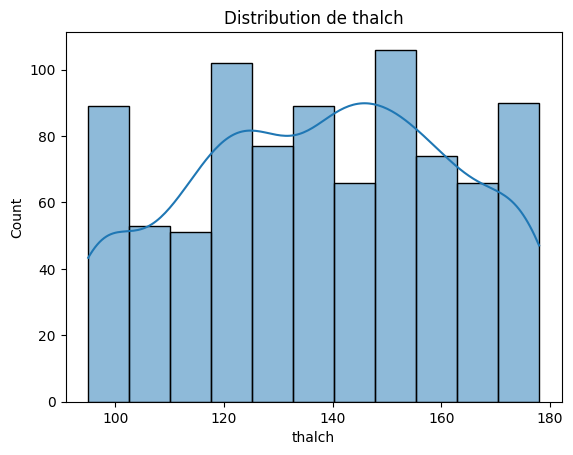

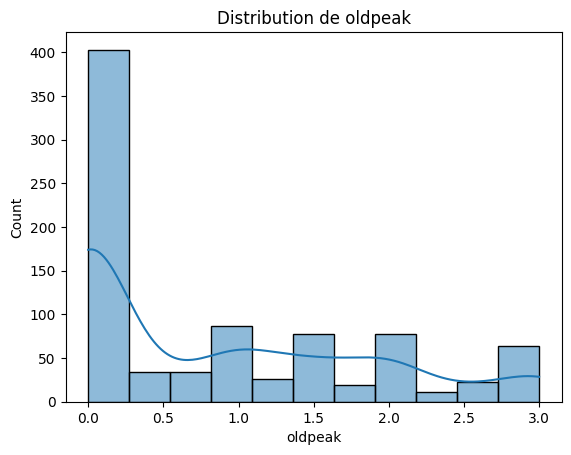

age          0
sex          0
dataset      0
cp           0
trestbps     0
chol         0
fbs         90
restecg      2
thalch       0
exang       55
oldpeak      0
num          0
dtype: int64
(918, 12)


In [194]:
#In order to strategize on missing data, we will first check their distributions
for col in number_columns:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution de {col}')
    plt.show()

#We replace NANs with median
imputer = SimpleImputer(strategy='median')

df[number_columns] = imputer.fit_transform(df[number_columns])

#Now we normalize data
scaler = StandardScaler()
df[number_columns] = scaler.fit_transform(df[number_columns])

print(df.isna().sum())
print(df.shape)

EDA and preprocessing #5: Categorical values distributions and missing values management

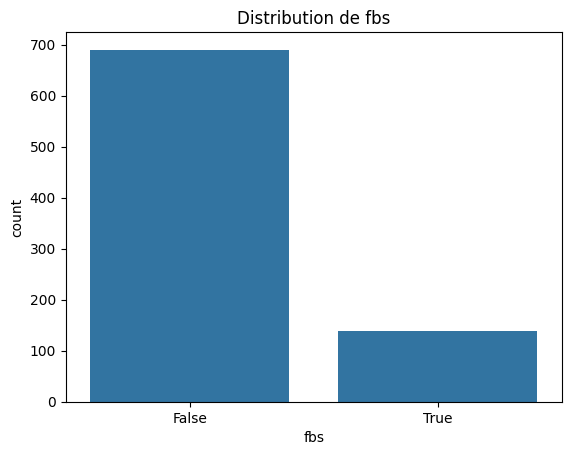

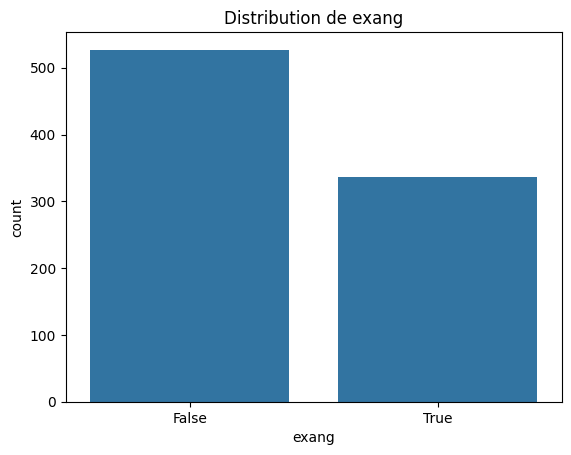

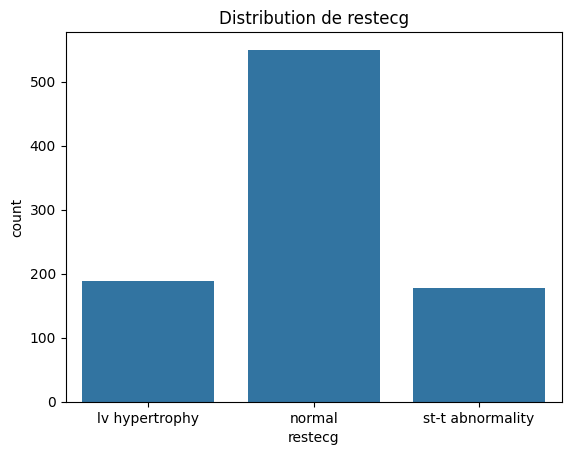

age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64
(918, 12)


In [195]:
#Missing values management for categorical data
cat_cols_with_nan = ['fbs', 'exang', 'restecg']

#In order to strategize on missing data, we will first check their distributions
for col in cat_cols_with_nan:
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution de {col}')
    plt.show()

#We replace NANs with mode (most_frequent)
imputer = SimpleImputer(strategy='most_frequent')

df[cat_cols_with_nan] = imputer.fit_transform(df[cat_cols_with_nan])

print(df.isna().sum())
print(df.shape)

EDA and preprocessing #6: Statistical tests and feature engineering on categorical variables

In [196]:
# 'dataset' feature is related to traceability. We drop it.
df.drop(labels=['dataset'], axis=1, inplace= True)

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cat_cols= df.select_dtypes(include=['object', 'bool']).columns.tolist()
for col in cat_cols:
    contingency = pd.crosstab(df[col], df['num'])
    chi2, p, _, _ = chi2_contingency(contingency)
    v = cramers_v(contingency)
    print(f"Feature: {col} | Chi2 p-value: {p:.4f} | Cramer's V: {v:.3f}")

# 'Sex', 'cp' and 'exang' show p-values as 0 and Cramer's V's >=0.3. They are deemed both 'statistically' and 'clinically'
# Despite low Cramer's V value, we will keep 'fbs' and 'restecg' based on their low p-values and their 'clinical relevance'
print(df.isna().sum())
print(df.shape)

Feature: sex | Chi2 p-value: 0.0000 | Cramer's V: 0.300
Feature: cp | Chi2 p-value: 0.0000 | Cramer's V: 0.308
Feature: fbs | Chi2 p-value: 0.0011 | Cramer's V: 0.124
Feature: restecg | Chi2 p-value: 0.0000 | Cramer's V: 0.129
Feature: exang | Chi2 p-value: 0.0000 | Cramer's V: 0.429
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64
(918, 11)


EDA and preprocessing #6: ANOVA and feature engineering on numerical variables

In [197]:
# Preparation of ANOVA
X_num = df[number_columns]
y = df['num']

# ANOVA F-test
F_value, p_value = f_classif(X_num, y)

# Résultat dans un DataFrame
anova_result = pd.DataFrame({
    'Feature': number_columns,
    'F-value': F_value,
    'p-value': p_value
}).sort_values(by='F-value', ascending=False)

print(anova_result)

# All p-values are below 0.05 which suggests a significant assocition to target
# Yet low F-values for 'trestbps' and 'chol' indicate low discriminiation
# We decide to keep them nonetheless because we deem them 'clinically significant'
print(df.isna().sum())
print(df.shape)

    Feature    F-value       p-value
4   oldpeak  53.616594  1.298034e-40
3    thalch  41.573779  4.783154e-32
0       age  31.619512  1.074251e-24
1  trestbps   3.451695  8.250192e-03
2      chol   2.413118  4.749006e-02
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64
(918, 11)


EDA and preprocessing #7: Data encoding

In [198]:
#Display unique values for deciding on encoding strategy
cat_cols_auto = df.select_dtypes(include=['object', 'bool']).columns.tolist()

for col in cat_cols_auto:
    print(f"Valeurs uniques pour la colonne '{col}':")
    print(df[col].unique())
    print(f"Nombre de modalités : {df[col].nunique()}")
    print('-' * 40)

# Ordinal encoding with order defined for 'cp'
cp_order = ['typical angina', 'atypical angina', 'non-anginal', 'asymptomatic']
ordinal_encoder = OrdinalEncoder(categories=[cp_order])
df['cp_encoded'] = ordinal_encoder.fit_transform(df[['cp']])

# One-hot encoding
onehot_cols = [col for col in cat_cols_auto if col != 'cp']
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' pour éviter multicolinéarité

onehot_encoded = onehot_encoder.fit_transform(df[onehot_cols])
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(onehot_cols))

# Concaténer le one-hot encodé au df original et supprimer les colonnes originales
onehot_df.index = df.index
df = pd.concat([df, onehot_df], axis=1)
df.drop(columns=onehot_cols + ['cp'], inplace=True)

print(df.head())
print(df.isna().sum())
print(df.shape)
print(onehot_df.shape)
print(df.index.equals(onehot_df.index))

Valeurs uniques pour la colonne 'sex':
['Male' 'Female']
Nombre de modalités : 2
----------------------------------------
Valeurs uniques pour la colonne 'cp':
['typical angina' 'asymptomatic' 'non-anginal' 'atypical angina']
Nombre de modalités : 4
----------------------------------------
Valeurs uniques pour la colonne 'fbs':
[True False]
Nombre de modalités : 2
----------------------------------------
Valeurs uniques pour la colonne 'restecg':
['lv hypertrophy' 'normal' 'st-t abnormality']
Nombre de modalités : 3
----------------------------------------
Valeurs uniques pour la colonne 'exang':
[False True]
Nombre de modalités : 2
----------------------------------------
         age  trestbps      chol    thalch   oldpeak  num  cp_encoded  \
id                                                                      
1   1.082217  0.866102 -0.256602  0.512815  1.528699    0         0.0   
2   1.537052  1.831960  1.013692 -1.275058  0.690818    2         3.0   
3   1.537052 -0.743662 -0.

Model Training preparation

/var/folders/9m/2x6dfbbn0cq5m_g98d1wpw640000gn/T/ipykernel_57390/1923240353.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='pastel')


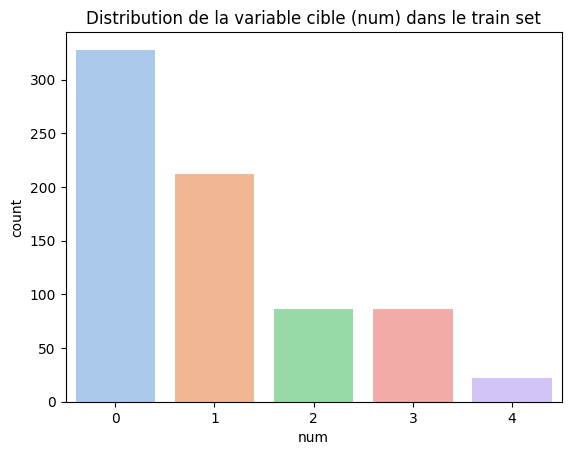

Original dataset shape: Counter({0: 328, 1: 212, 3: 86, 2: 86, 4: 22})
Resampled dataset shape: Counter({3: 328, 0: 328, 4: 328, 1: 328, 2: 328})


In [203]:
#Dataset split into training dataset and test dataset
X = df.drop('num', axis=1)
y = df['num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Check balance between classes in training set
sns.countplot(x=y_train, palette='pastel')
plt.title('Distribution de la variable cible (num) dans le train set')
plt.show()

#Classes are highly imbalanced. We proceed with SMOTE
# Avant SMOTE
print('Original dataset shape:', Counter(y_train))

# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Après SMOTE
print('Resampled dataset shape:', Counter(y_train_res))



Training and Model Evaluation

{'accuracy_log_reg': 0.47282608695652173, 'precision_log_reg': 0.5594308576591013, 'recall_log_reg': 0.47282608695652173, 'f1_log_reg': 0.5045393314578666}


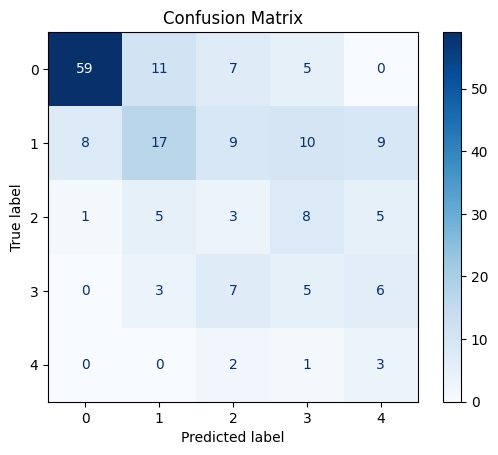

              precision    recall  f1-score   support

           0       0.87      0.72      0.79        82
           1       0.47      0.32      0.38        53
           2       0.11      0.14      0.12        22
           3       0.17      0.24      0.20        21
           4       0.13      0.50      0.21         6

    accuracy                           0.47       184
   macro avg       0.35      0.38      0.34       184
weighted avg       0.56      0.47      0.50       184



In [ ]:
#Train a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_res, y_train_res)

#Evaluate its performance on the test set
y_pred = log_reg.predict(X_test)


#Plot the Accuracy, Recall, Precision, F1-score and comment the results.
#Average is 'wheighted' because we perform a multi-class test and classes are imbalanced in test set.
metrics_log_reg = {
    'accuracy_log_reg': accuracy_score(y_test, y_pred),
    'precision_log_reg': precision_score(y_test, y_pred, average='weighted'),
    'recall_log_reg': recall_score(y_test, y_pred, average='weighted'),
    'f1_log_reg': f1_score(y_test, y_pred, average='weighted')
}
print(metrics_log_reg)
#Metrics are above 20% which suggests an "acceptable overall performance".
#Meaning, it will tell be all right for telling if you have heart disease.
#Still, can it tell "How far"? 

#Confusion Matrix
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

#Classification report
print(classification_report(y_test, y_pred))

#Confusion matrix and Classfication report confirm the "hunch" from metrics
#Class 0: The model predicts this class well — which makes sense since it is the most represented.
#Class 1: Moderate performance — still acceptable but with noticeable loss in recall.
#Classes 2, 3, and 4: Very low performance.
#Precision is especially low (particularly for class 2).
#Class 4 has very low support (only 6 observations).
#The F1-scores are very low → the model is almost unable to distinguish these classes.

#Although the class imbalance in the test set may contribute to these results, Logistic Regression might not be the best choice for this prediction task.”